In [2]:
import os, time, cv2, numpy as np
from pathlib import Path
from collections import deque, Counter
from ultralytics import YOLO
import torch
from sklearn.cluster import KMeans

In [ ]:
#device and models
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
model_det  = YOLO("yolov8n.pt")
model_pose = YOLO("yolov8n-pose.pt")
model_det.to(device); model_pose.to(device)

#path and video open helpers
def diag_path(p):
    p = Path(p)
    print("[CWD]", os.getcwd())
    print("[Given path]", p)
    print("[Absolute]", p.resolve())
    print("[Exists?]", p.exists())
    if p.parent.exists():
        print("[Dir list]", [q.name for q in list(p.parent.iterdir())[:12]])

def open_video_any(p):
    p = str(p)
    tried = []
    for api in (cv2.CAP_FFMPEG, cv2.CAP_ANY, cv2.CAP_AVFOUNDATION):
        cap = cv2.VideoCapture(p, apiPreference=api)
        ok = bool(cap.isOpened())
        tried.append(("FFMPEG" if api==cv2.CAP_FFMPEG else "ANY" if api==cv2.CAP_ANY else "AVFOUNDATION", ok))
        if ok: return cap, tried
    raise IOError(f"Could not open video with any backend. Tried: {tried}")

#draw label
def draw_label(img, text, xy, color_bgr=(0,0,0)):
    x, y = xy
    font, scale, thick = cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
    (tw, th), _ = cv2.getTextSize(text, font, scale, thick)
    pad = 6
    cv2.rectangle(img, (x, y - th - 2*pad), (x + tw + 2*pad, y), color_bgr, -1)
    cv2.putText(img, text, (x + pad, y - pad), font, scale, (255,255,255), thick, cv2.LINE_AA)
    return img

#color utils
def normalize_v_clahe(bgr, clip_limit=2.0, tile_grid_size=(8,8)):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    v_eq = clahe.apply(v)
    hsv_eq = cv2.merge([h,s,v_eq])
    return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)

def soft_fg_mask(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    s = s.astype(np.float32)/255.0
    v = v.astype(np.float32)/255.0
    w = (s**0.8) * (1.0 - np.clip((v-0.75)*4.0, 0, 1))
    return np.clip(w,0,1)

def dominant_color(bgr_roi, k=3, sample_max=5000, use_weight=True):
    if bgr_roi is None or bgr_roi.size == 0: return (0,0,0),(0,0,0)
    img = normalize_v_clahe(bgr_roi)
    flat = img.reshape(-1,3).astype(np.float32)
    if flat.shape[0] > sample_max:
        idx = np.random.choice(flat.shape[0], sample_max, replace=False)
        flat = flat[idx]
        weight = soft_fg_mask(img).reshape(-1)[idx] if use_weight else None
    else:
        weight = soft_fg_mask(img).reshape(-1) if use_weight else None
    v = cv2.cvtColor(flat.reshape(-1,1,3).astype(np.uint8), cv2.COLOR_BGR2HSV)[:,0,2]
    good = (v > 20) & (v < 245)
    flat = flat[good]
    if use_weight and weight is not None: weight = weight[good]
    if flat.shape[0] < k: k = max(1, flat.shape[0])
    km = KMeans(n_clusters=k, n_init=6, random_state=42)
    if use_weight and weight is not None:
        reps = np.clip((weight*3).astype(int)+1, 1, 5)
        km.fit(np.repeat(flat, reps, axis=0))
    else:
        km.fit(flat)
    center = km.cluster_centers_.astype(np.uint8)[np.argmax(np.bincount(km.labels_))]
    bgr = tuple(int(x) for x in center.tolist())
    hsv = cv2.cvtColor(np.uint8([[bgr]]), cv2.COLOR_BGR2HSV)[0,0]
    return bgr, tuple(int(x) for x in hsv.tolist())

COLOR_BINS = [
    ("black",   dict(v_max=55)),
    ("gray",    dict(s_max=40, v_min=56, v_max=200)),
    ("white",   dict(s_max=40, v_min=201)),
    ("red",     dict(h_ranges=[(0,10),(170,180)], s_min=50, v_min=50)),
    ("orange",  dict(h_ranges=[(10,22)], s_min=50, v_min=50)),
    ("brown",   dict(h_ranges=[(5,25)], s_min=50, v_min=20, v_max=120)),
    ("yellow",  dict(h_ranges=[(23,35)], s_min=40, v_min=60)),
    ("green",   dict(h_ranges=[(36,85)], s_min=35, v_min=40)),
    ("cyan",    dict(h_ranges=[(86,95)], s_min=35, v_min=40)),
    ("blue",    dict(h_ranges=[(96,130)], s_min=35, v_min=40)),
    ("purple",  dict(h_ranges=[(131,160)], s_min=35, v_min=40)),
    ("pink",    dict(h_ranges=[(161,169)], s_min=30, v_min=60)),
]
def hsv_to_name(hsv):
    h,s,v = hsv
    if v <= 55: return "black"
    if s <= 40 and 56 <= v <= 200: return "gray"
    if s <= 40 and v > 200: return "white"
    for name, cond in COLOR_BINS[3:]:
        h_ranges = cond.get("h_ranges", [])
        s_min = cond.get("s_min", 0); s_max = cond.get("s_max", 255)
        v_min = cond.get("v_min", 0); v_max = cond.get("v_max", 255)
        ok_h = any(lo <= h <= hi for (lo,hi) in h_ranges) if h_ranges else True
        if ok_h and (s_min <= s <= s_max) and (v_min <= v <= v_max):
            return name
    hue_names = [("red",0),("orange",16),("yellow",29),("green",60),("cyan",90),("blue",113),("purple",145),("pink",165)]
    best = min(hue_names, key=lambda x: min(abs(h-x[1]), 180-abs(h-x[1])))
    return best[0]

#ROI split via pose
KPT = {"l_shoulder":5, "r_shoulder":6, "l_hip":11, "r_hip":12, "l_knee":13, "r_knee":14}
def clip_box(x1,y1,x2,y2,W,H):
    x1 = max(0, min(int(x1), W-1)); y1 = max(0, min(int(y1), H-1))
    x2 = max(0, min(int(x2), W-1)); y2 = max(0, min(int(y2), H-1))
    if x2 <= x1: x2 = min(W-1, x1+1)
    if y2 <= y1: y2 = min(H-1, y1+1)
    return x1,y1,x2,y2

def y_from_kpts_or_ratio(box, kpts_xy, img_h, use_knee=True):
    x1,y1,x2,y2 = box
    top,bottom = y1,y2
    if kpts_xy is not None:
        def safe_avg(ids):
            pts=[kpts_xy[i][1] for i in ids if not np.isnan(kpts_xy[i][0]) and not np.isnan(kpts_xy[i][1])]
            return np.mean(pts) if pts else np.nan
        y_sh  = safe_avg([KPT["l_shoulder"], KPT["r_shoulder"]])
        y_hip = safe_avg([KPT["l_hip"], KPT["r_hip"]])
        y_knee= safe_avg([KPT["l_knee"], KPT["r_knee"]]) if use_knee else np.nan
        if not np.isnan(y_sh) and not np.isnan(y_hip) and top <= y_sh < y_hip <= bottom:
            split_upper = (y_sh*0.4 + y_hip*0.6)
            split_lower = (y_hip*0.9 + y_knee*0.1) if (not np.isnan(y_knee) and y_hip < y_knee <= bottom) else y_hip + 0.05*(bottom-top)
            return int(split_upper), int(split_lower)
    h = bottom-top
    return top + int(0.43*h), top + int(0.55*h)

def extract_upper_lower_rois(img, box, kpts_xy=None):
    H,W = img.shape[:2]
    x1,y1,x2,y2 = clip_box(*box, W,H)
    yU,yL = y_from_kpts_or_ratio((x1,y1,x2,y2), kpts_xy, H)
    u_box = clip_box(x1,y1,x2,yU,W,H); l_box = clip_box(x1,yL,x2,y2,W,H)
    upper = img[u_box[1]:u_box[3], u_box[0]:u_box[2]]
    lower = img[l_box[1]:l_box[3], l_box[0]:l_box[2]]
    return {"upper":{"roi":upper,"box":u_box}, "lower":{"roi":lower,"box":l_box}}

#detector wrapper for tracking path
def detect_people_colors(frame_bgr, conf=0.35):
    res = model_pose.predict(frame_bgr, conf=conf, verbose=False, device=device)[0]
    boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
    kpts  = res.keypoints.xy.cpu().numpy() if res.keypoints is not None else None
    dets=[]
    for i, box in enumerate(boxes):
        x1,y1,x2,y2 = [int(v) for v in box.tolist()]
        parts = extract_upper_lower_rois(frame_bgr, (x1,y1,x2,y2), kpts[i] if kpts is not None else None)
        det={"box":(x1,y1,x2,y2)}
        u_roi,u_box = parts["upper"]["roi"], parts["upper"]["box"]
        if u_roi.size>0:
            bgr_u,hsv_u = dominant_color(u_roi, k=3)
            det["top"]={"name":hsv_to_name(hsv_u),"hsv":hsv_u,"bgr":bgr_u,"box":u_box}
        l_roi,l_box = parts["lower"]["roi"], parts["lower"]["box"]
        if l_roi.size>0:
            bgr_l,hsv_l = dominant_color(l_roi, k=3)
            det["bottom"]={"name":hsv_to_name(hsv_l),"hsv":hsv_l,"bgr":bgr_l,"box":l_box}
        dets.append(det)
    return dets

#IOUTracker
def iou_xyxy(a,b):
    ax1,ay1,ax2,ay2=a; bx1,by1,bx2,by2=b
    ix1,iy1=max(ax1,bx1),max(ay1,by1); ix2,iy2=min(ax2,bx2),min(ay2,by2)
    iw,ih=max(0,ix2-ix1),max(0,iy2-iy1); inter=iw*ih
    if inter<=0: return 0.0
    area_a=(ax2-ax1)*(ay2-ay1); area_b=(bx2-bx1)*(by2-by1)
    return inter/max(area_a+area_b-inter,1e-6)

class IOUTracker:
    def __init__(self,iou_thr=0.35,max_missed=15,hist_len=12):
        self.iou_thr=iou_thr; self.max_missed=max_missed; self.hist_len=hist_len
        self.next_id=1; self.tracks={}
    def _new(self,det):
        tid=self.next_id; self.next_id+=1
        self.tracks[tid]={"box":det["box"],"miss":0,
                          "top_hist":deque(maxlen=self.hist_len),"bot_hist":deque(maxlen=self.hist_len),
                          "top_hsv":deque(maxlen=self.hist_len),"bot_hsv":deque(maxlen=self.hist_len)}
        self._push(tid,det); return tid
    def _push(self,tid,det):
        if det.get("top"): self.tracks[tid]["top_hist"].append(det["top"]["name"]); self.tracks[tid]["top_hsv"].append(det["top"]["hsv"])
        if det.get("bottom"): self.tracks[tid]["bot_hist"].append(det["bottom"]["name"]); self.tracks[tid]["bot_hsv"].append(det["bottom"]["hsv"])
    def _mode(self,qq): return Counter(list(qq)).most_common(1)[0][0] if qq else None
    def _hsvmean(self,qq):
        if not qq: return None
        hs=np.array(qq,dtype=np.float32); ang=hs[:,0]/180*np.pi*2
        h=(np.degrees(np.arctan2(np.sin(ang).mean(), np.cos(ang).mean()))/2); h=h+180 if h<0 else h
        return (int(h),int(hs[:,1].mean()),int(hs[:,2].mean()))
    def update(self,dets):
        unmatched_d=set(range(len(dets))); unmatched_t=set(self.tracks.keys()); matches=[]; iou={}
        for ti in list(self.tracks.keys()):
            iou[ti]={di:iou_xyxy(self.tracks[ti]["box"],dets[di]["box"]) for di in range(len(dets))}
        while True:
            best=(None,None,0.0)
            for ti in list(unmatched_t):
                for di in list(unmatched_d):
                    v=iou[ti][di]
                    if v>best[2]: best=(ti,di,v)
            if best[2]<self.iou_thr: break
            ti,di,_=best; matches.append((ti,di)); unmatched_t.discard(ti); unmatched_d.discard(di)
        out=[]
        for ti,di in matches:
            det=dets[di]; tr=self.tracks[ti]; tr["box"]=det["box"]; tr["miss"]=0; self._push(ti,det)
            out.append((ti,det,{"top_name":self._mode(tr["top_hist"]), "bot_name":self._mode(tr["bot_hist"]),
                                "top_hsv":self._hsvmean(tr["top_hsv"]), "bot_hsv":self._hsvmean(tr["bot_hsv"])}))
        for ti in list(unmatched_t):
            self.tracks[ti]["miss"]+=1
            if self.tracks[ti]["miss"]>self.max_missed: self.tracks.pop(ti,None)
        for di in unmatched_d:
            det=dets[di]; tid=self._new(det); tr=self.tracks[tid]
            out.append((tid,det,{"top_name":self._mode(tr["top_hist"]), "bot_name":self._mode(tr["bot_hist"]),
                                 "top_hsv":self._hsvmean(tr["top_hsv"]), "bot_hsv":self._hsvmean(tr["bot_hsv"])}))
        return out

#video loop: precise colors only
def process_frame_colors_precise(frame_bgr, conf=0.4):
    H,W = frame_bgr.shape[:2]
    res = model_pose.predict(frame_bgr, conf=conf, verbose=False, device=device)[0]
    annotated = frame_bgr.copy()
    boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
    kpts  = res.keypoints.xy.cpu().numpy() if res.keypoints is not None else None
    for i, box in enumerate(boxes):
        parts = extract_upper_lower_rois(frame_bgr, [int(v) for v in box.tolist()], kpts[i] if kpts is not None else None)
        for key,label_at in (("upper","top"),("lower","bottom")):
            b = parts[key]["box"]; roi = parts[key]["roi"]
            if roi.size:
                bgr,hsv = dominant_color(roi,k=3); name = hsv_to_name(hsv)
                cv2.rectangle(annotated,(b[0],b[1]),(b[2],b[3]), bgr, 2)
                y = b[1] if key=="upper" else b[3]
                draw_label(annotated, f"{label_at.capitalize()}: {name}", (b[0], y), color_bgr=bgr)
    return annotated

def process_video_colors_only(input_path, output_path, conf=0.4, scale=1.0, preview_every=15):
    from IPython.display import display, clear_output
    from IPython.display import Image as IPyImage
    cap, tried = open_video_any(input_path); print("[Open backends tried]:", tried)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_w,out_h=int(W*scale),int(H*scale)
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (out_w,out_h))
    t0= time.time(); i=0
    while True:
        ok, frame = cap.read()
        if not ok: break
        if scale!=1.0: frame=cv2.resize(frame,(out_w,out_h),interpolation=cv2.INTER_LINEAR)
        ann = process_frame_colors_precise(frame, conf=conf)
        writer.write(ann)
        if preview_every and i%preview_every==0:
            _,buf=cv2.imencode(".jpg",ann); clear_output(wait=True); display(IPyImage(data=buf.tobytes()))
            print(f"Frame: {i}")
        i+=1
    cap.release(); writer.release()
    print(f"✅ Saved: {output_path} | Frames: {i} | {i/max(time.time()-t0,1e-6):.2f} fps")

#video loop: with tracking
def process_video_with_tracking(input_path, output_path="output_tracked.mp4", conf=0.35, scale=1.0, preview_every=15):
    from IPython.display import display, clear_output
    from IPython.display import Image as IPyImage
    cap, tried = open_video_any(input_path); print("[Open backends tried]:", tried)
    in_fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    in_w,in_h=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_w,out_h=int(in_w*scale),int(in_h*scale)
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), in_fps, (out_w,out_h))
    tracker = IOUTracker(iou_thr=0.35,max_missed=20,hist_len=12)
    i=0; t0=time.time()
    while True:
        ok, frame = cap.read()
        if not ok: break
        if scale!=1.0: frame=cv2.resize(frame,(out_w,out_h),interpolation=cv2.INTER_LINEAR)
        dets = detect_people_colors(frame, conf=conf)
        matches = tracker.update(dets)
        canvas = frame.copy()
        for tid,det,sm in matches:
            x1,y1,x2,y2 = det["box"]; cv2.rectangle(canvas,(x1,y1),(x2,y2),(90,90,90),1)
            if "top" in det:
                ub=det["top"]["box"]; name=sm["top_name"] or det["top"]["name"]; bgr=det["top"]["bgr"]
                cv2.rectangle(canvas,(ub[0],ub[1]),(ub[2],ub[3]), bgr,2); draw_label(canvas,f"Top: {name}",(ub[0],ub[1]),bgr)
            if "bottom" in det:
                lb=det["bottom"]["box"]; name=sm["bot_name"] or det["bottom"]["name"]; bgr=det["bottom"]["bgr"]
                cv2.rectangle(canvas,(lb[0],lb[1]),(lb[2],lb[3]), bgr,2); draw_label(canvas,f"Bottom: {name}",(lb[0],lb[3]),bgr)
            draw_label(canvas, f"ID {tid}", (x1,y1), (60,60,60))
        writer.write(canvas)
        if preview_every and i%preview_every==0:
            _,buf=cv2.imencode(".jpg",canvas); clear_output(wait=True); display(IPyImage(data=buf.tobytes()))
            print(f"Frame: {i} | Tracks: {len(tracker.tracks)}")
        i+=1
    cap.release(); writer.release()
    print(f"✅ Tracked video saved: {output_path} | Frames: {i} | {i/max(time.time()-t0,1e-6):.2f} fps")

print("process video withtracking.")


process video withtracking.


In [2]:
#imgsz
def process_frame_colors_pretty_fast(frame_bgr, conf=0.4, imgsz=512):
    H,W = frame_bgr.shape[:2]
    res = model_pose.predict(frame_bgr, conf=conf, verbose=False, device=device, imgsz=imgsz, vid_stride=1)[0]
    annotated = frame_bgr.copy()

    boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
    kpts = res.keypoints.xy.cpu().numpy() if res.keypoints is not None else None

    for i, box in enumerate(boxes):
        kp_xy = kpts[i] if (kpts is not None and i < kpts.shape[0]) else None
        parts = extract_upper_lower_rois(frame_bgr, box, kp_xy)

        # Upper
        u_box = shrink_box(parts["upper"]["box"], frac=0.06, W=W, H=H)
        u_roi = frame_bgr[u_box[1]:u_box[3], u_box[0]:u_box[2]]
        if u_roi.size:
            bgr_u, hsv_u = dominant_color_tuned(u_roi, k=4)
            name_u = hsv_to_name_tuned(hsv_u)
            cv2.rectangle(annotated, (u_box[0],u_box[1]), (u_box[2],u_box[3]), bgr_u, 2)
            draw_label(annotated, f"Top: {name_u}", (u_box[0], u_box[1]), color_bgr=bgr_u)

        # Lower
        l_box = shrink_box(parts["lower"]["box"], frac=0.06, W=W, H=H)
        l_roi = frame_bgr[l_box[1]:l_box[3], l_box[0]:l_box[2]]
        if l_roi.size:
            bgr_l, hsv_l = dominant_color_tuned(l_roi, k=4)
            name_l = hsv_to_name_tuned(hsv_l)
            cv2.rectangle(annotated, (l_box[0],l_box[1]), (l_box[2],l_box[3]), bgr_l, 2)
            draw_label(annotated, f"Bottom: {name_l}", (l_box[0], l_box[3]), color_bgr=bgr_l)

    return annotated


def process_video_colors_only_fast(input_path, output_path, conf=0.4, scale=1.0,
                                   imgsz=512, preview_every=20, frame_skip=1, max_frames=None):
    cap, tried = open_video_any(input_path)
    print("[Open backends tried]:", tried)

    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    assert W>0 and H>0, "Bad video meta."

    out_w, out_h = int(W*scale), int(H*scale)
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (out_w, out_h))

    t0, frame_id, wrote = time.time(), 0, 0
    while True:
        ok, frame = cap.read()
        if not ok: break
        if max_frames is not None and frame_id >= max_frames: break

        if frame_id % frame_skip != 0:
            if scale != 1.0:
                frame = cv2.resize(frame, (out_w, out_h), interpolation=cv2.INTER_LINEAR)
            writer.write(frame)
            frame_id += 1
            continue

        if scale != 1.0:
            frame = cv2.resize(frame, (out_w, out_h), interpolation=cv2.INTER_LINEAR)

        annotated = process_frame_colors_pretty_fast(frame, conf=conf, imgsz=imgsz)
        writer.write(annotated)
        wrote += 1

        if preview_every and wrote % preview_every == 0:
            _, buf = cv2.imencode(".jpg", annotated)
            clear_output(wait=True)
            display(IPyImage(data=buf.tobytes()))
            print(f"Frames processed: {wrote} (skip {frame_skip}) | imgsz={imgsz}")

        frame_id += 1

    cap.release(); writer.release()
    dt = time.time() - t0
    print(f"\n Saved: {output_path} | Frames total: {frame_id} | processed: {wrote} | {frame_id/max(dt,1e-6):.2f} fps")


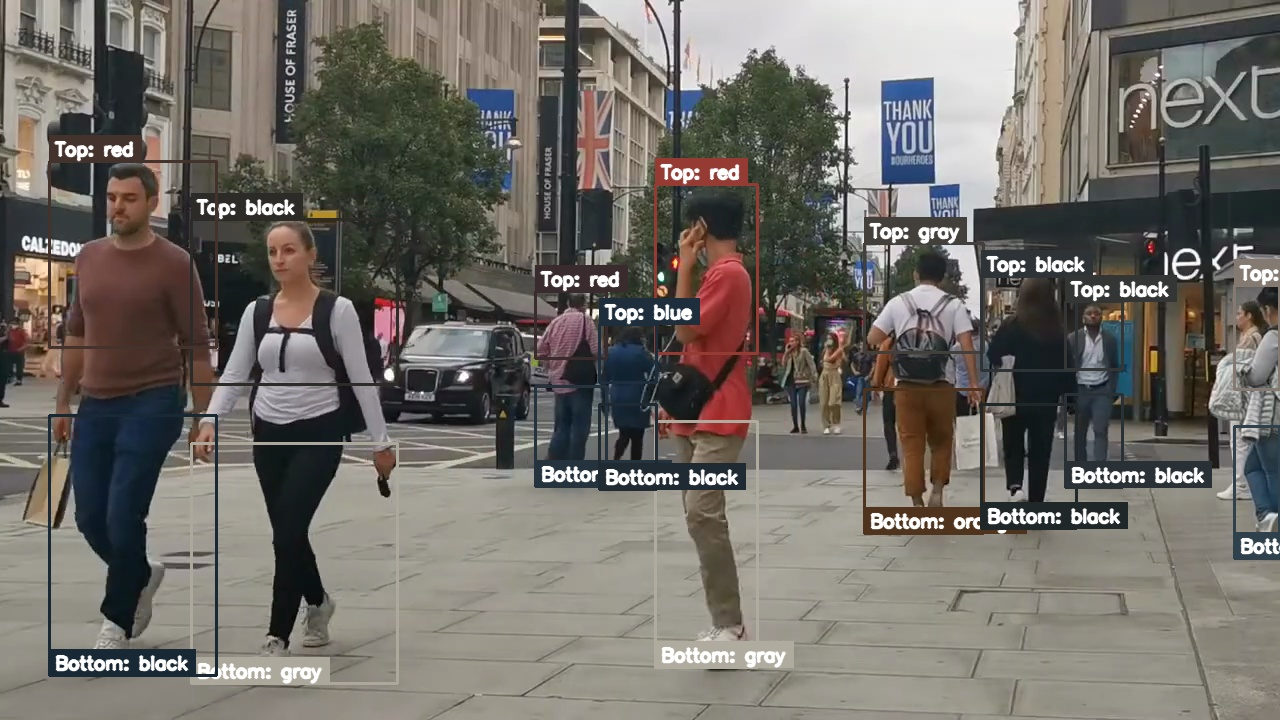

Frame: 435
✅ Saved: /Users/azin/Codes/output_colors.mp4 | Frames: 444 | 5.02 fps


In [3]:
process_video_colors_only(
    input_path="/Users/azin/Codes/Untitled.mp4",
    output_path="/Users/azin/Codes/output_colors.mp4",
    conf=0.40,
    scale=1.0,
    preview_every=15
)
